In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import warnings

from matplotlib import pyplot as plt

data = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


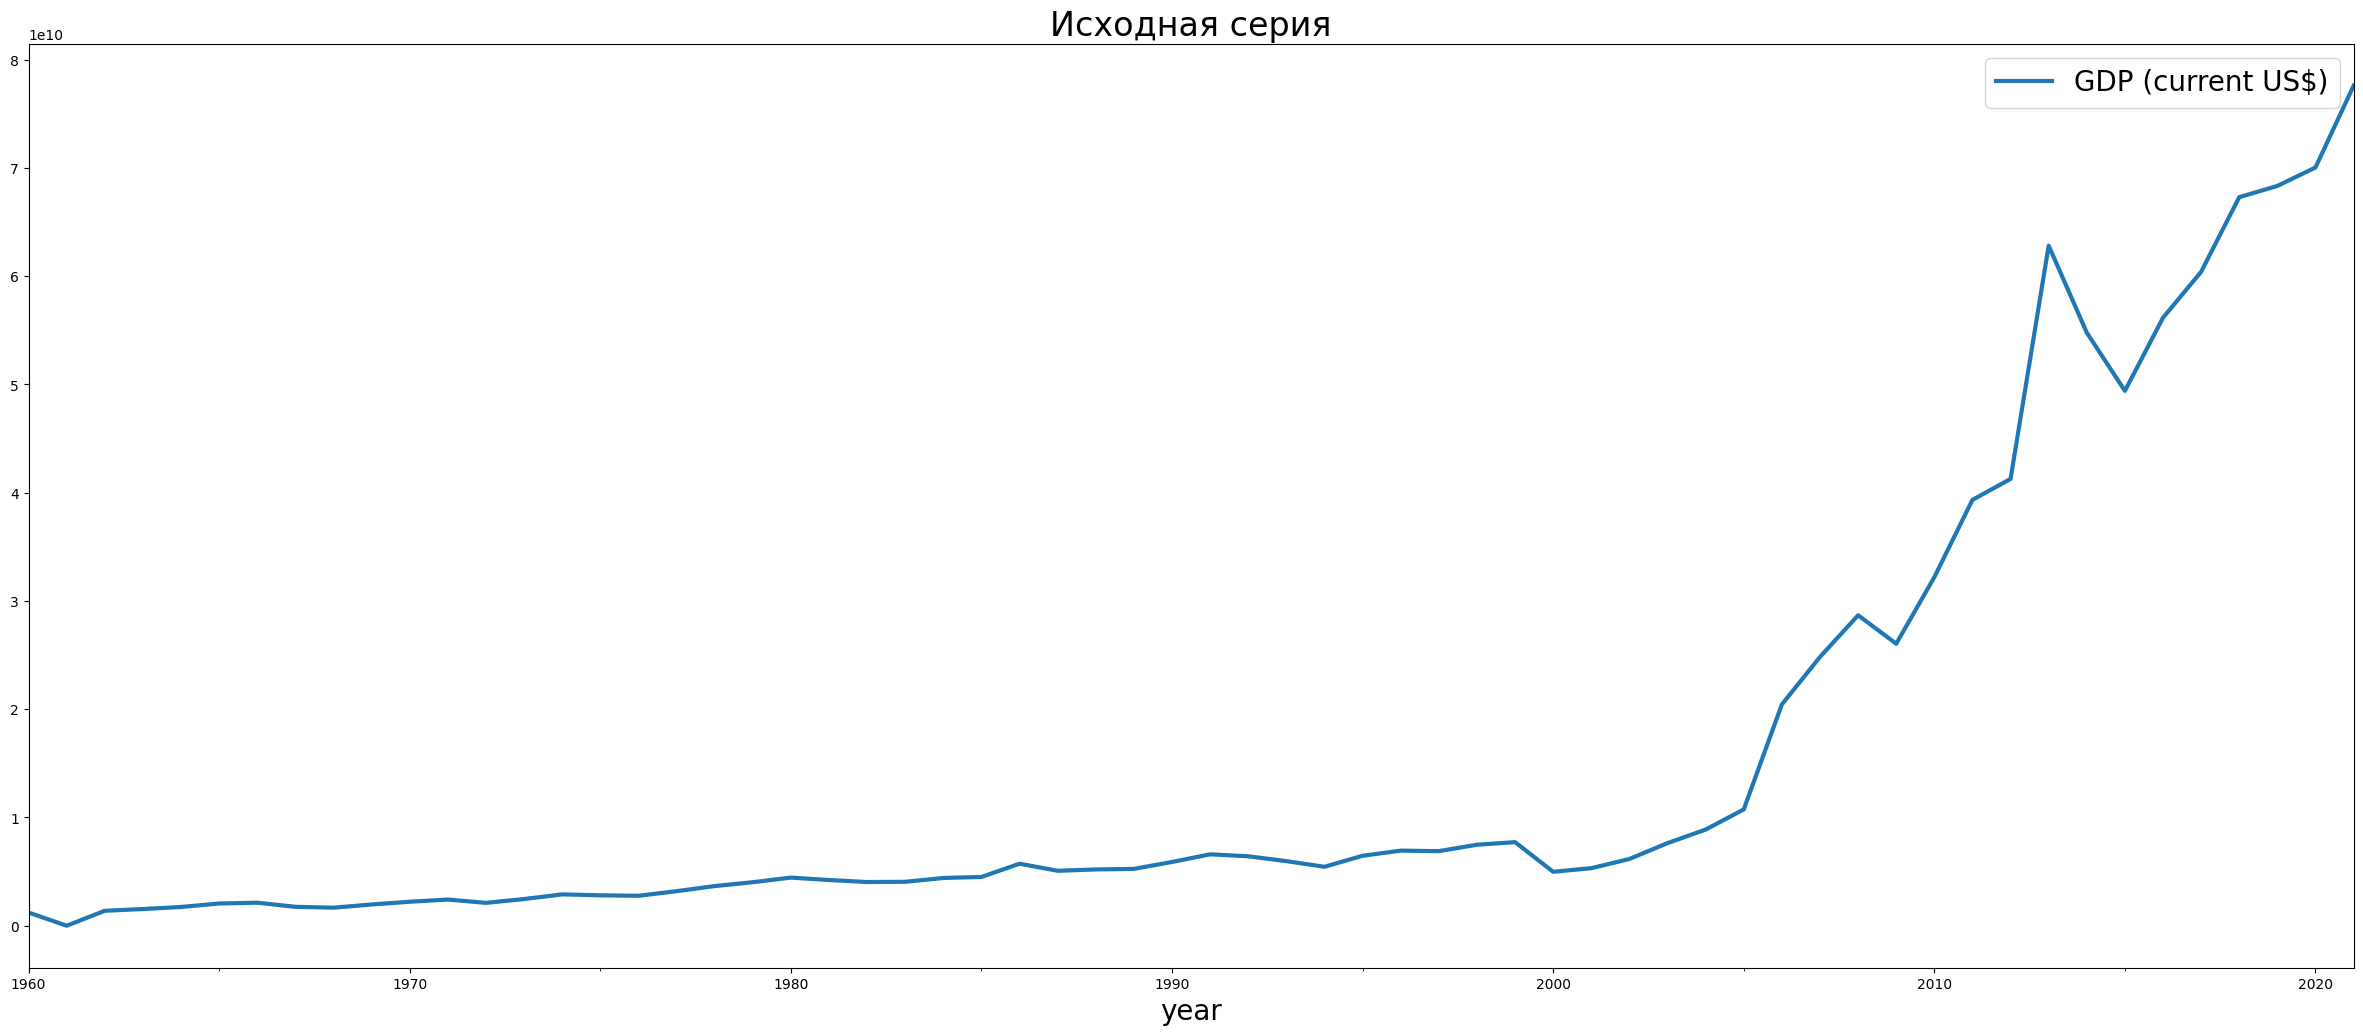

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot(title='Исходная серия')

plt.show()

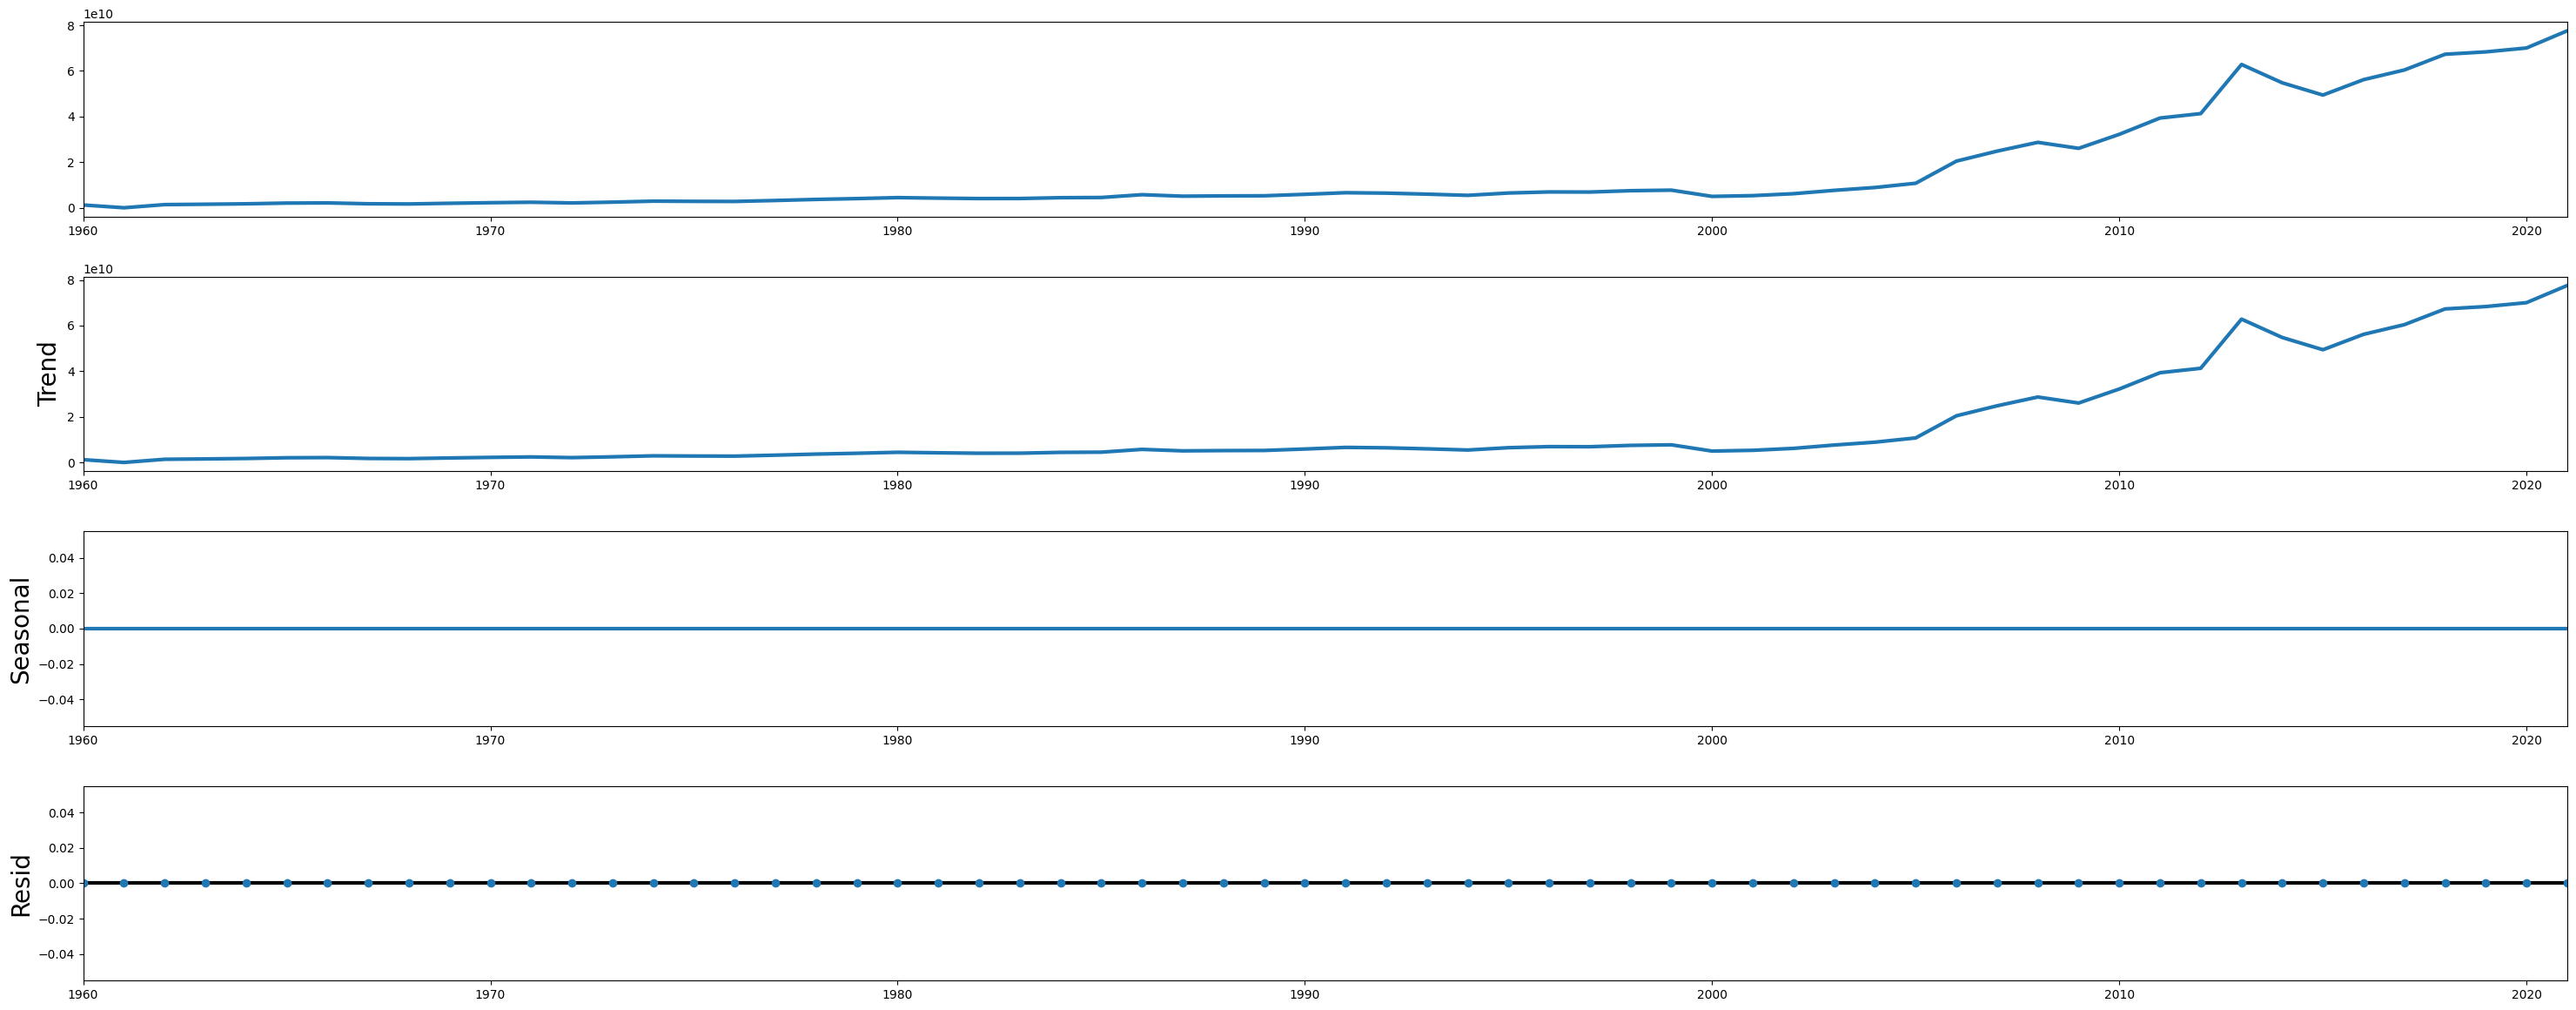

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

decomposition = seasonal_decompose(data, model='additive') 
decomposition.plot()
pyplot.show()

ВЫВОД: В представленном временном ряде присутствует тренд, однако сезонность не выражена.

In [5]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
print(train_df.shape,test_df.shape)

(59, 1) (3, 1)


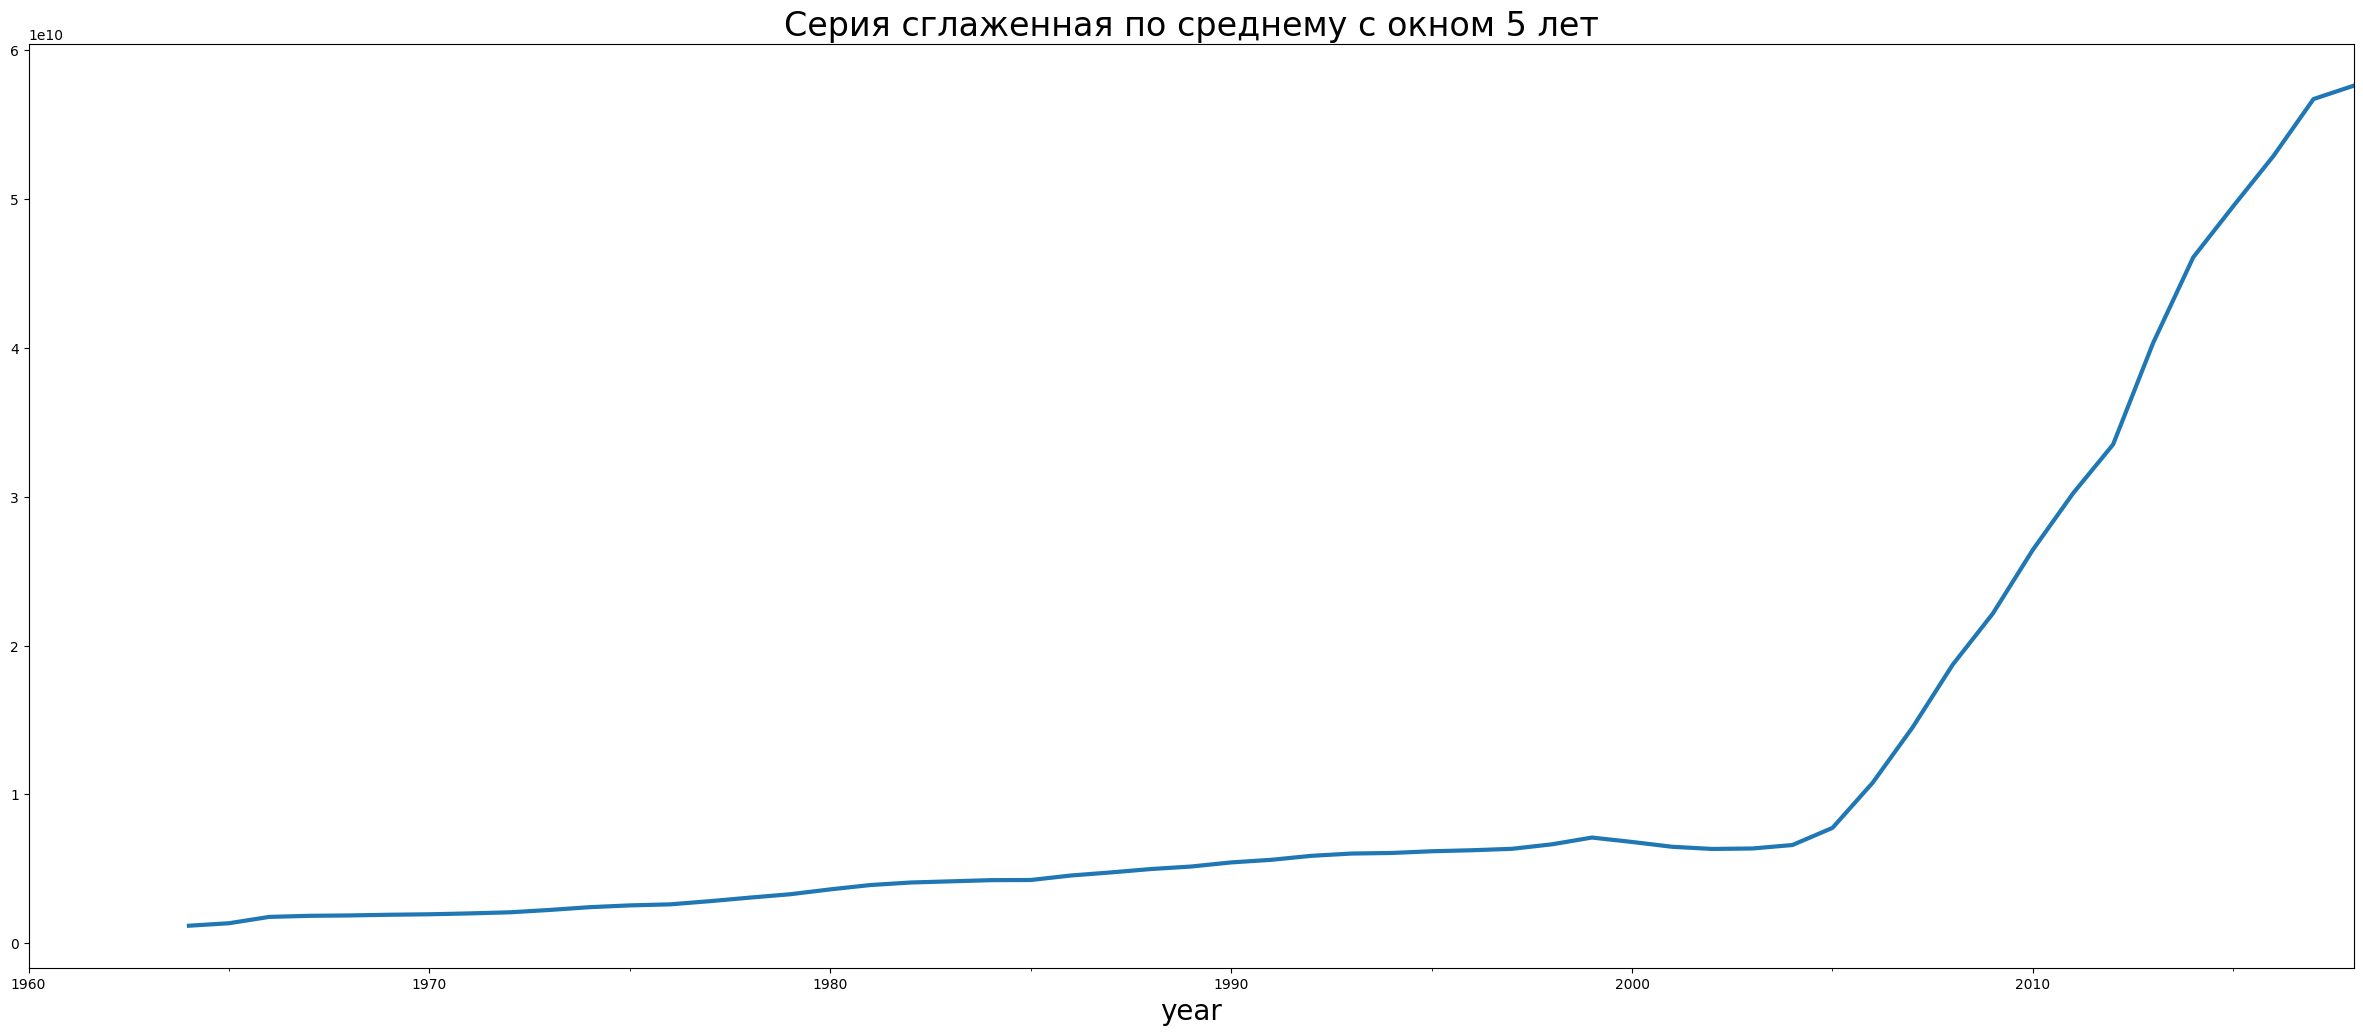

In [6]:

# Plots for Moving Average (window = 5 yeas)
train_df['GDP (current US$)'].rolling(window=5).mean().plot(title='Серия сглаженная по среднему с окном 5 лет')
plt.show()

Cглаженная серия с окном 5 лет хорошо показывает тенденцию сохраняя некоторые колебания при этом устранив пики

In [7]:
from statsmodels.tsa.stattools import adfuller

def check_adf(df):
    test1 = adfuller(df)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

check_adf(train_df['GDP (current US$)'])

df_diff1 = train_df['GDP (current US$)'].diff().dropna()
df_diff2 = df_diff1.diff().dropna()
check_adf(df_diff1)
check_adf(df_diff2)
df_diff3 = df_diff2.diff().dropna()
check_adf(df_diff3)

adf:  0.6529066974885386
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен
adf:  -1.6702483038320752
p-value:  0.44650293297139043
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
adf:  -2.6408690561284875
p-value:  0.08484116917837708
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
adf:  -4.779623784828588
p-value:  5.948327640223472e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен



Получили стационарный ряд после третьего дифференцирования с alfa=0.05. Графики ниже наглядно показывают отсутствие тренда, однако разброс значений в сезонах значительно больше в последнее десятилетие. При alfa=0.10 можно ограничится вторым порядком дифференцирования.

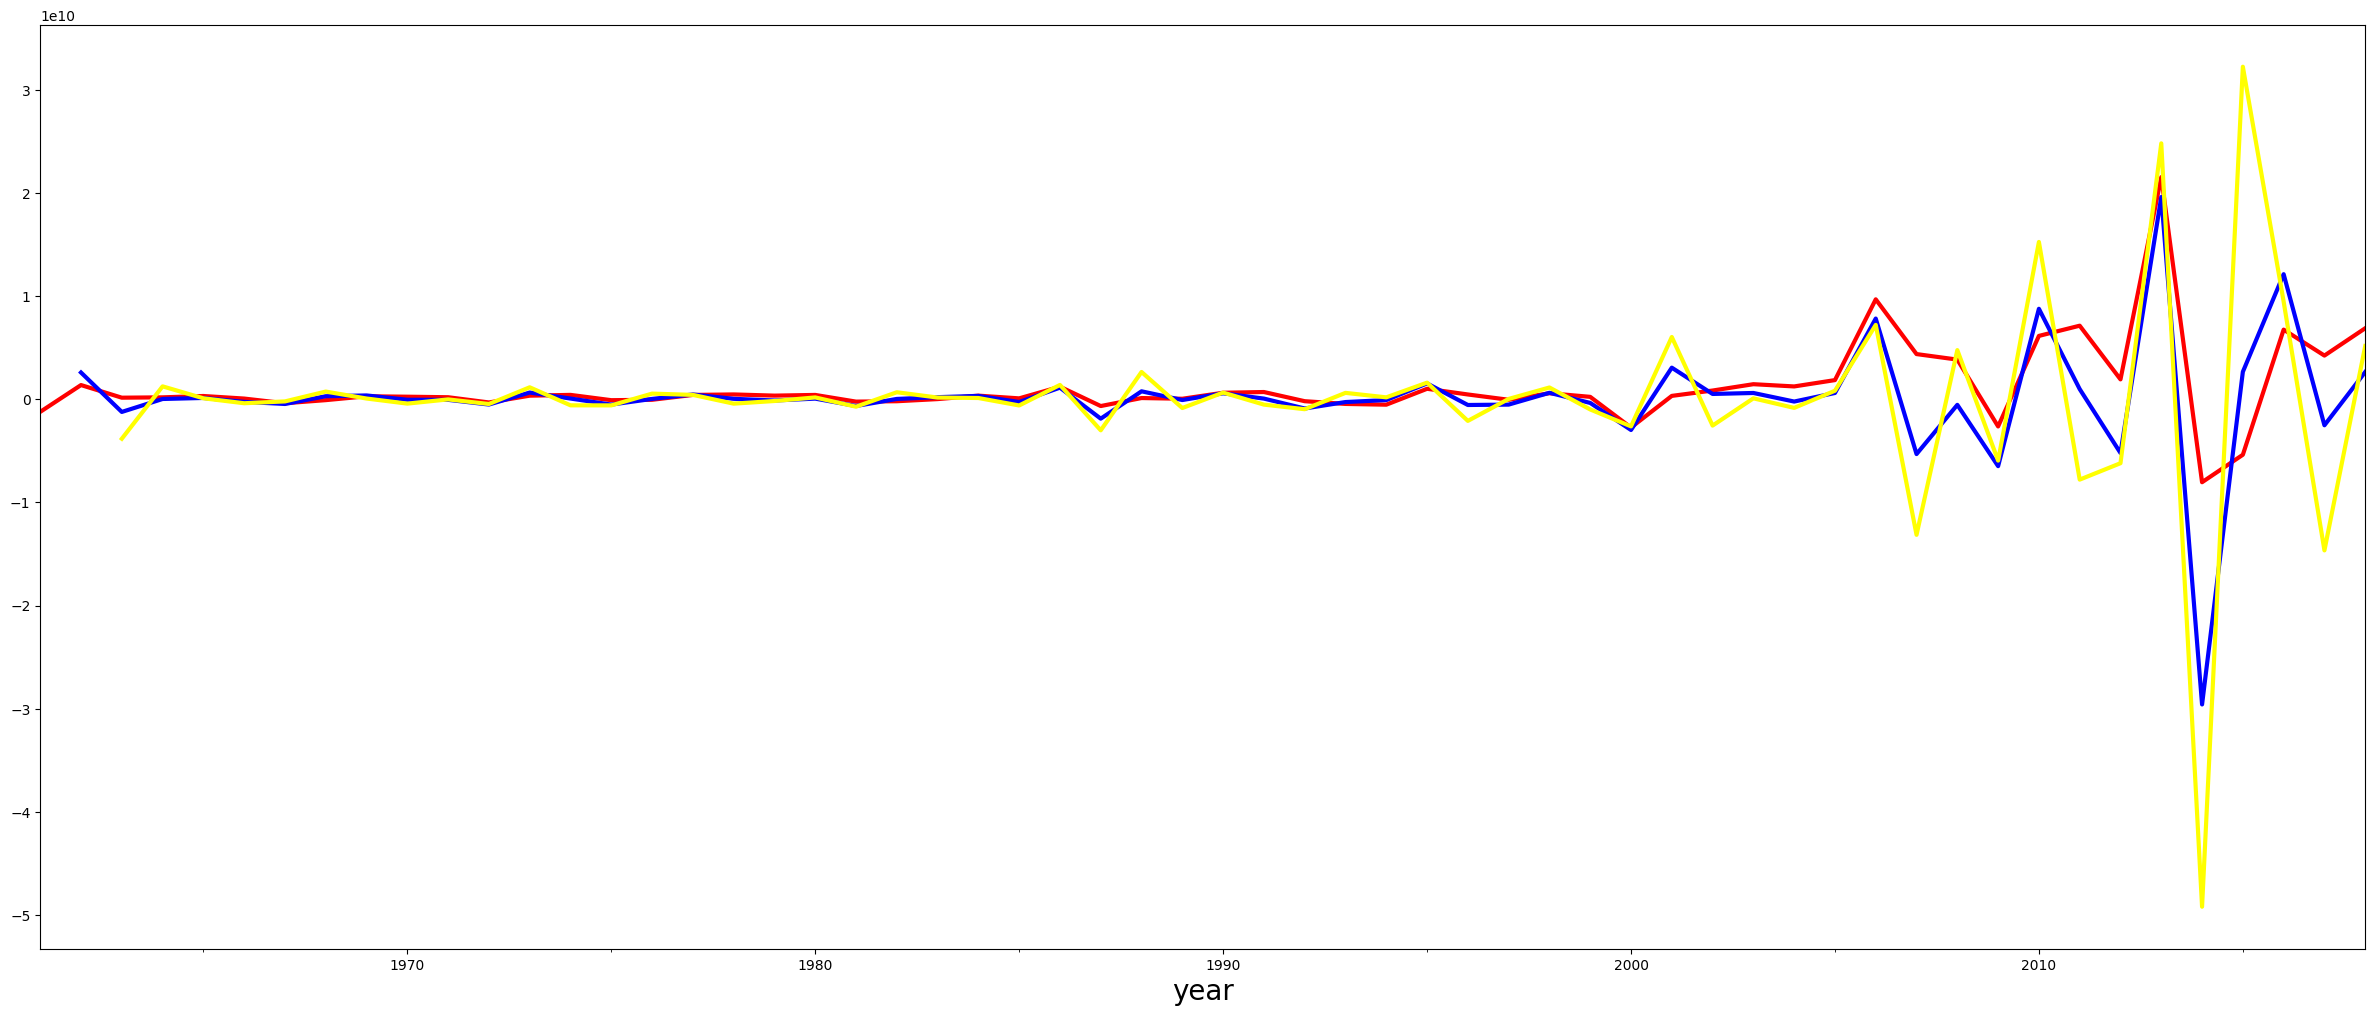

In [8]:
df_diff1.plot(color='red')
df_diff2.plot(color='blue')
df_diff3.plot(color='yellow');

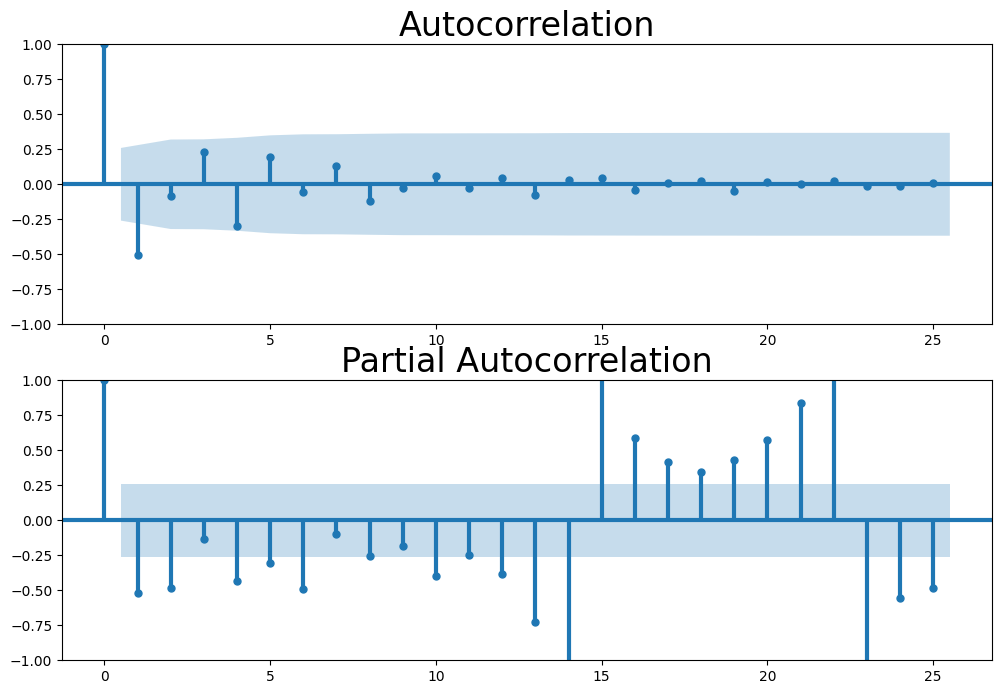

In [9]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff2.values.squeeze(), lags=25, ax=ax1, alpha=0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff2, lags=25, ax=ax2, alpha=0.05)

PACF не сходится и мы не можем определить хвост. Соответственно трудно определить параметр p для автокорреляции. Несмотря на то, что на лагах 14, 15, 22 и 23 мы наблюдаем полную корреляцию, вряд ли эти значения статистически значимы.

ACF показывает, что значимым является q=1. 

Представленные графики не дают нам четкой картины для выбора p, поэтому мы будем тестировать модель ARMA для различных лагов.

In [10]:
# построим сетку для поиска лучшего AIC

warnings.filterwarnings('ignore')

def do_ARIMA(df,order):
    arima_model = ARIMA(df, order=order, enforce_stationarity=True, enforce_invertibility=True)
    arima_model_fit = arima_model.fit()
    return arima_model_fit.aic

N = 25 # размерность сетки

cutting_edge = 2690 # значения AIC выше указанной границы нам не интересны и возможно являются выбросом из за неточности вычислений

aic = np.empty((N,N))

d=3 # порядок дифференцирования

for p in range(1,N+1): # лаг для AR - авторегрессии
    for q in range(1,N+1): # лаг для MA - скользящего среднего
        try:
            aic_coeff = do_ARIMA(train_df['GDP (current US$)'],(p,d,q))
        except:
            aic_coeff = cutting_edge
        aic[p-1][q-1] = aic_coeff if aic_coeff < cutting_edge else cutting_edge


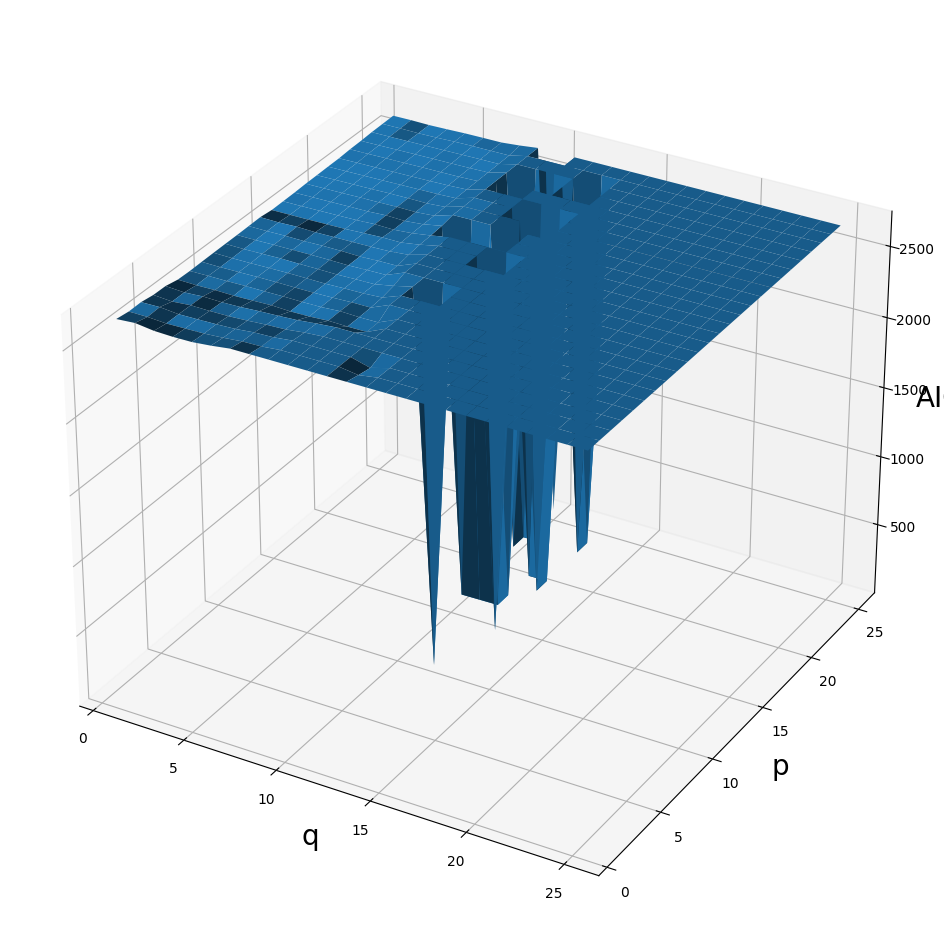

In [11]:
# визуализируем сетку

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

x_values = np.array([x for x in range(1,N+1)])
y_values = np.array([y for y in range(1,N+1)])

X,Y = np.meshgrid(x_values,y_values)

Z = aic

# Plot the 3D surface
ax.plot_surface(X,Y,Z)

ax.set(xlabel='q', ylabel='p', zlabel='AIC')

plt.show()


In [12]:
print('Best params:(p,q)={}, AIC={:.3f}'.format(np.unravel_index(aic.argmin(), aic.shape),aic[np.unravel_index(aic.argmin(), aic.shape)]))

Best params:(p,q)=(9, 11), AIC=46.000


In [13]:
# ищем оптимальные параметры при помощи pmdarima

import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    max_p=25,
    start_q=1,
    max_q=25,
    d=3,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)
#smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.267 seconds


In [14]:
# смотрим лучшее значение в окрестности параметров полученных в pmdarima

auto_arim_area = aic[:8][0:8]
auto_arim_area.shape

print('Around auto best params:(p,q)={}, AIC={:.3f}'.format(np.unravel_index(auto_arim_area.argmin(), auto_arim_area.shape),auto_arim_area[np.unravel_index(auto_arim_area.argmin(), auto_arim_area.shape)]))

Around auto best params:(p,q)=(5, 3), AIC=2626.067


Вывод: По сетке AIC на графике выше мы видим, что пространство изобилует локальным выбросами как в сторону минимума так и в сторону максимума (мы срезали максимумы на графике, чтобы сохранить наглядный масшаб). Вряд ли можно полагаться на полученный результат глобального минимума: Best params:(p,q)=(9, 11), AIC=46.00. Cкорее всего полученный результат не обладает достаточной значимостью. Мы также можем видеть, что и поиск при помощи pm.auto_arima не дал нам оптимального результата. Алгоритм оптимизации, используемый в этом пакете скорее всего ушел в локальный минимум. Нам легко удалось обнаружить по сетке еще меньшее значение: Around auto best params:(p,q)=(5, 3), AIC=2626.067. Однако, возможно, что значимость этого значения ниже.

In [15]:
import warnings
from pandas import Series
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(
        train,
        test,
        arima_order):

    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train,test, p_values, d_values, q_values):
    scores = []
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
#                    print("Evaluating the settings: ", p, d, q)
                    mse = evaluate_arima_model(train,test, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
#                    print('ARIMA%s MSE=%.2e' % (order,mse))
                    scores.append([p,d,q,mse])
                except Exception as exception:
#                    print("Exception occured...", type(exception).__name__, "\n", exception)
                    pass

    print('Best ARIMA%s MSE=%.2e' % (best_cfg, best_score))
    return scores

# evaluate parameters
p_values = [2,5,9,14,15,22,23]
d_values = [1,2,3]
q_values = [1,3,4,5,11]
warnings.filterwarnings("ignore")
scores = evaluate_models(train_df['GDP (current US$)'],test_df['GDP (current US$)'], p_values, d_values, q_values)



Best ARIMA(2, 2, 1) MSE=5.67e+18


In [16]:
scores = pd.DataFrame(scores, columns=['p','d','q','mse'])
scores.sort_values(by=['mse'],ascending=True).head(5)

,p,d,q,mse
5,2,2,1,5.669646e+18
0,2,1,1,9.177123e+18
15,5,1,1,1.247830e+19
11,2,3,3,1.423057e+19
10,2,3,1,1.627826e+19


Еще одна проверка выполнена для поиска модели с меньшей средне-квадратичной ошибкой на тестовой выборке. Мы включили в сетку также порядок дифференцирования 2, так как мы видели, что ряд можно признать стационарным приняв уровень доверия 90% (alpha=0.10). Таким образом, лучшие предсказания получены с параметрами p=2,d=2,q=1. 

AIC=2731.213913519646


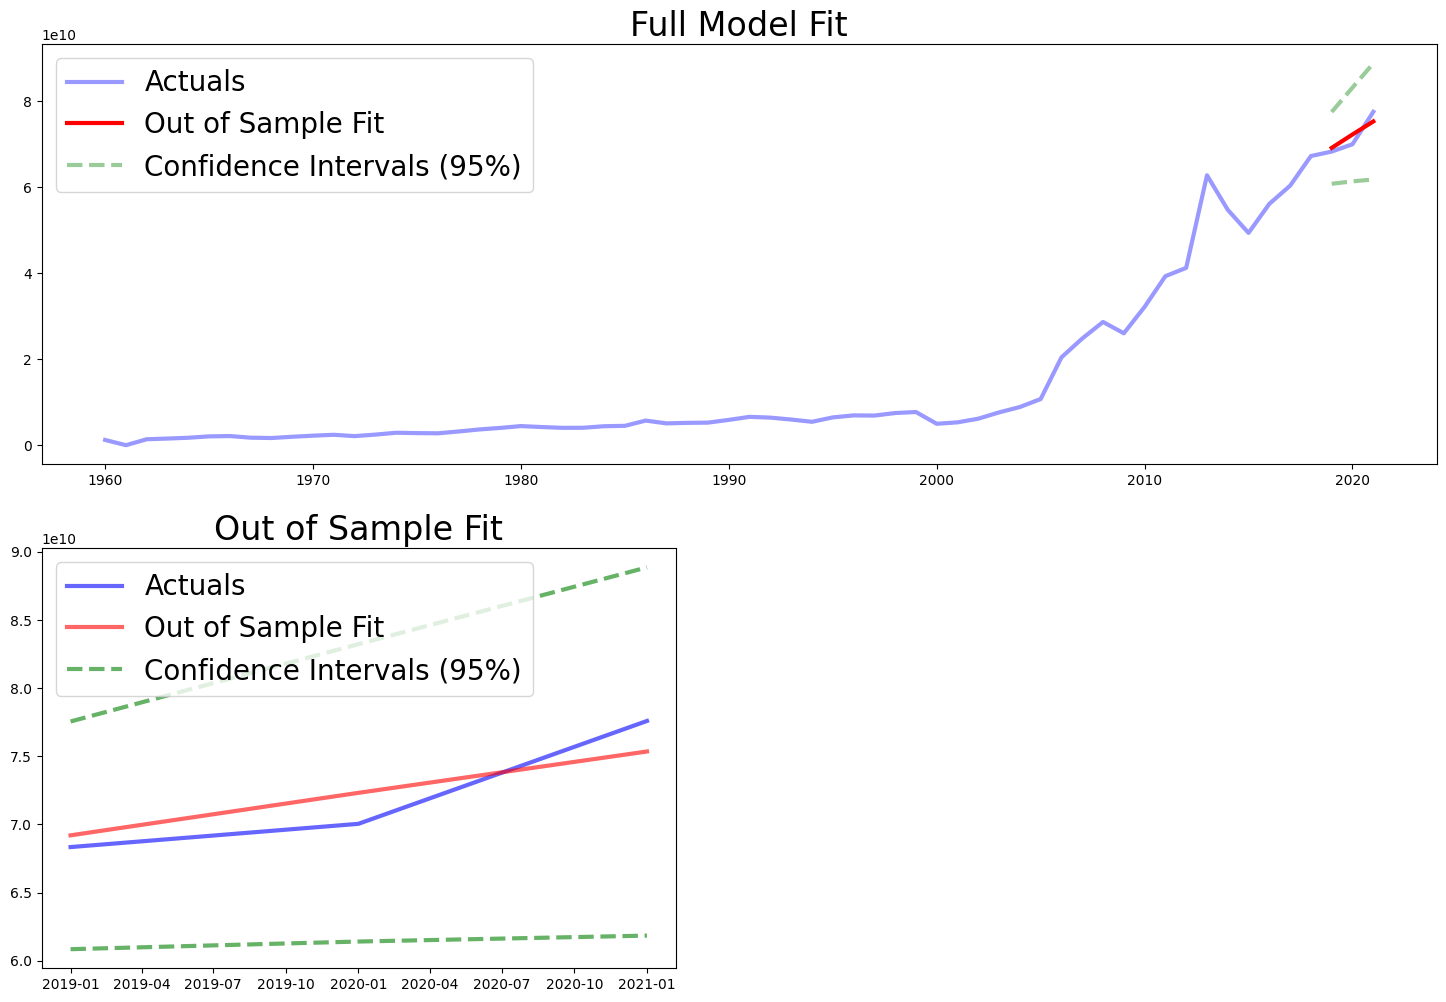

In [17]:

def draw_arima_model(
        data,
        train,
        test,
        arima_order):
    
    seas_model = SARIMAX(
        train, order=(1, 1, 2)
    )

    seas_model_fit = seas_model.fit(disp=False)

    print('AIC={}'.format(seas_model_fit.aic))

    pred_df = pd.DataFrame(index=data.index)

    pred_df["model_preds"] = seas_model_fit.predict(
        start=test.index[0], end=test.index[-1]
    )


    pred_df = pd.concat([data,pred_df],axis=1)

    forecast = seas_model_fit.get_forecast(len(test.index))
    forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

    pred_df = pd.concat([pred_df,forecast_df], axis=1)
    pred_df.rename(columns = {'lower GDP (current US$)':'model_preds_lower','upper GDP (current US$)':'model_preds_upper'},inplace=True)

    
    plt.rcParams["figure.figsize"] = 18, 12

    plt.subplot(2, 1, 1)
    plt.plot(pred_df['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.4,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.4,
    )

    plt.title("Full Model Fit", size=24)
    plt.legend()

    plt.subplot(2, 2, 3)

    plt.plot(
        pred_df.loc[test_df.index]['GDP (current US$)'], color="blue", label="Actuals", alpha=0.6
        )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.6,
    )

    plt.title("Out of Sample Fit", size=24)
    plt.legend()

    plt.show()
    

draw_arima_model(data, train_df['GDP (current US$)'],test_df['GDP (current US$)'],(2,2,1))

Вывод: предсказания полученной модели Best ARIMA(2, 2, 1) MSE=5.67e+18 находятся в доверительно интервале  95%. Мы получили прямую линию, что говорит о простоте модели - модель не учитывает сезонность и другие факторы, и интервал предсказания достаточно короткий.

========================================================================================================================================================
Интерполяция и сэмплирование. Практика

In [18]:
# Проверяем данные на наличие пропущенных дат

print('Количество пропустков = {}, количество нулей = {}'.format(
    data.asfreq(freq='AS').isnull().sum()[0],
    data[data['GDP (current US$)']==0].count()[0]
    )
)

# заменяем нули на nan
data[data['GDP (current US$)']==0] = np.nan

# интерполируем пропущенные значения
data['GDP (current US$)'].interpolate(method='linear',inplace=True)

print('Количество пропустков = {}, количество нулей = {}'.format(
    data.asfreq(freq='AS').isnull().sum()[0],
    data[data['GDP (current US$)']==0].count()[0]
    )
)

Количество пропустков = 0, количество нулей = 1
Количество пропустков = 0, количество нулей = 0


In [19]:
# разделим интерполированные данные

train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
print(train_df.shape,test_df.shape)

(59, 1) (3, 1)


adf:  0.8030073326980085
p-value:  0.9916845572455876
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен
adf:  -1.825565224643599
p-value:  0.36784515276563473
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
adf:  -2.634634746007853
p-value:  0.08604813722197463
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
adf:  -4.825603687304062
p-value:  4.857318076799065e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


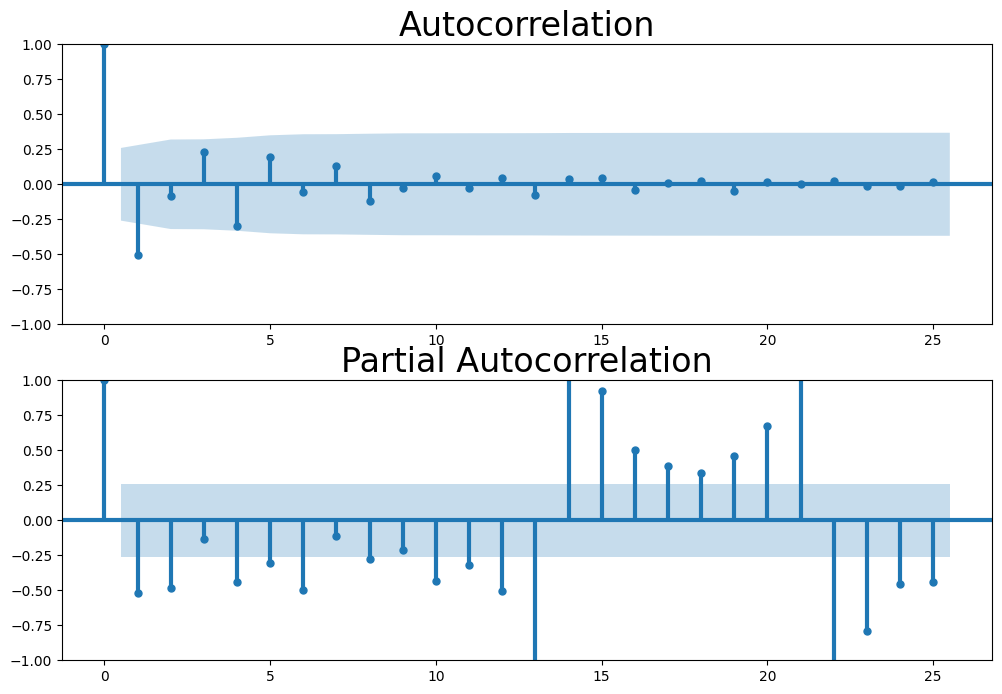

In [20]:
from statsmodels.tsa.stattools import adfuller

def check_adf(df):
    test1 = adfuller(df)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

check_adf(train_df['GDP (current US$)'])

df_diff1 = train_df['GDP (current US$)'].diff().dropna()
df_diff2 = df_diff1.diff().dropna()
check_adf(df_diff1)
check_adf(df_diff2)
df_diff3 = df_diff2.diff().dropna()
check_adf(df_diff3)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff2.values.squeeze(), lags=25, ax=ax1, alpha=0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff2, lags=25, ax=ax2, alpha=0.05)

AIC=2731.085140939278


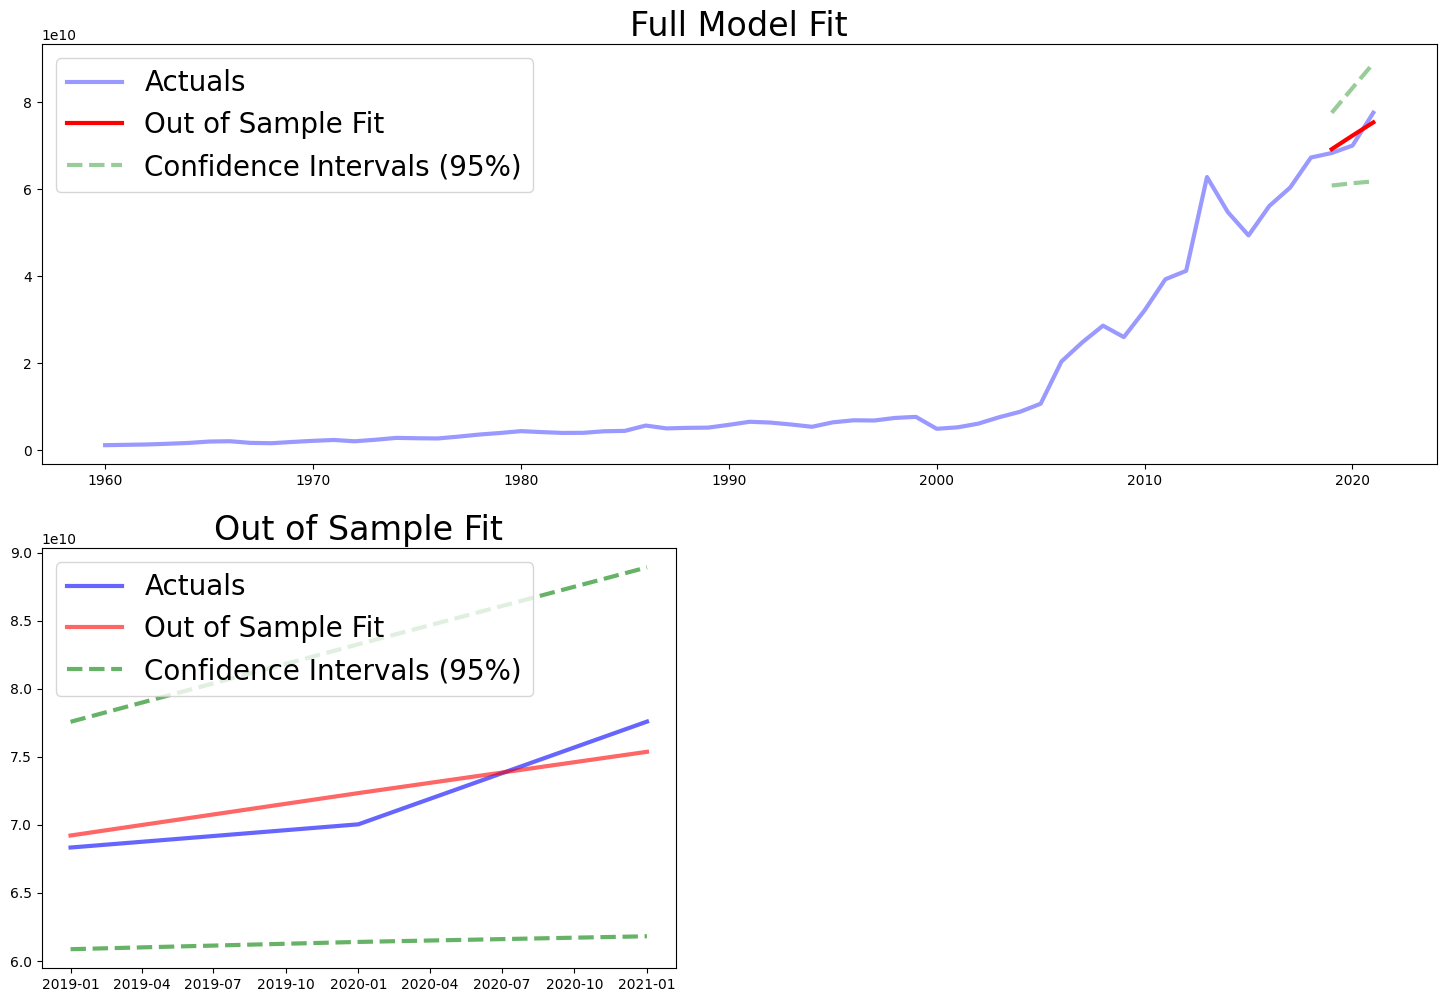

In [21]:
draw_arima_model(data, train_df['GDP (current US$)'],test_df['GDP (current US$)'],(2,2,1))

Вывод: проведенная замена пропущенного значения при помощи линейной интерполяции не повлияла на параметры моделей.

=============================================================================================================================

Модели прогнозирования гетероскедастичности. Валидация временных рядов

In [22]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(data)

for i, (train_index, test_index) in enumerate(train_test_groups):
     print(f"Fold {i}:")
     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
TRAIN size: 41 TEST size: 7
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
  Test:  index=[41 42 43 44 45 46 47]
Fold 1:
TRAIN size: 48 TEST size: 7
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
  Test:  index=[48 49 50 51 52 53 54]
Fold 2:
TRAIN size: 55 TEST size: 7
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
  Test:  index=[55 56 57 58 59 60 61]


Считаем волатильность по формуле:  **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [23]:
data["GDP_vol"] = (data['GDP (current US$)'] - data['GDP (current US$)'].shift(1))/data['GDP (current US$)'].shift(1)
data["GDP_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data["GDP_vol"].head()


year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

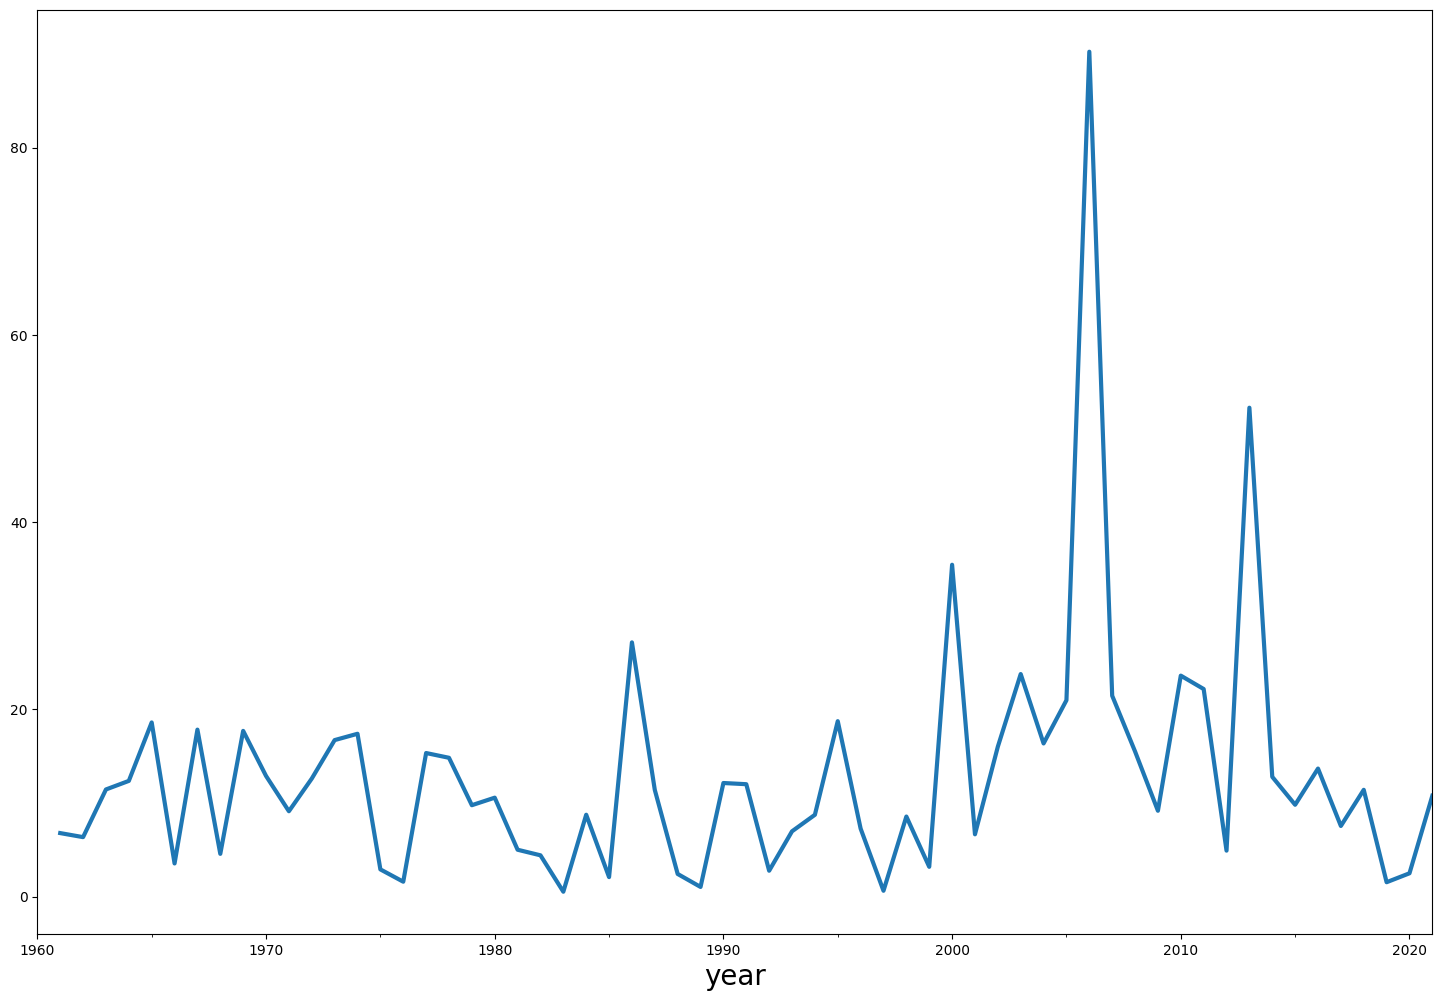

In [24]:
data["GDP_vol"].plot()
plt.show()

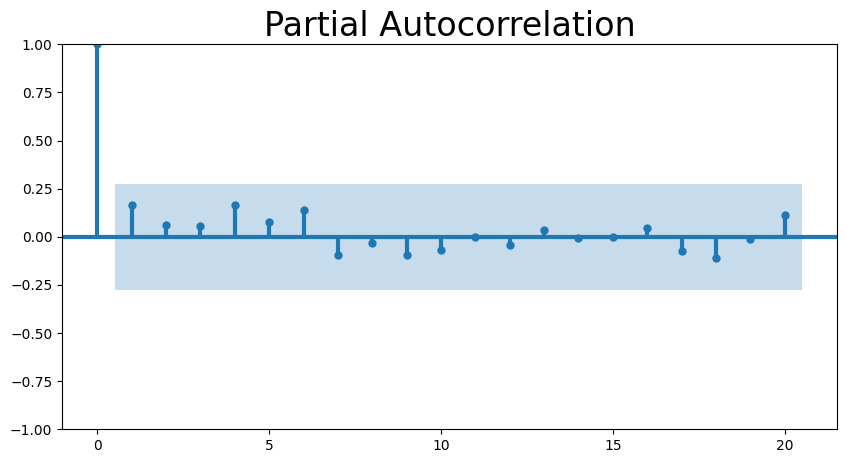

In [25]:
train_df = data.iloc[:-10]
test_df = data.iloc[-10:]


plt.rcParams["figure.figsize"] = 10, 5

sm.graphics.tsa.plot_pacf(train_df['GDP_vol'][1:], lags=20, method="ywm")
plt.show()

In [26]:
adfuller(train_df.GDP_vol[1:])

(-5.85237168956285,
 3.564518162179283e-07,
 0,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 324.0228637360376)

Значительный лаг = 4. Ряд волатильности стационарен. Построим модель GARCH(p=4, q=2)

In [27]:
# готовим ряд для GARCH зафиксировав индекс из исходного набора данных
garch_df = pd.DataFrame(data['GDP_vol'].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [28]:
from arch import arch_model

model = arch_model(garch_df["GDP_vol"].dropna(), p=4, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0] , update_freq=5
                          )
print(model_results.summary())

# сделаем предсказания
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]/100

Iteration:      5,   Func. Count:     49,   Neg. LLF: 197.47961867064672
Iteration:     10,   Func. Count:     94,   Neg. LLF: 196.378184770808
Iteration:     15,   Func. Count:    139,   Neg. LLF: 196.1226623939233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 196.11871156408958
            Iterations: 19
            Function evaluations: 175
            Gradient evaluations: 19
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -196.119
Distribution:                  Normal   AIC:                           408.237
Method:            Maximum Likelihood   BIC:                           423.692
                                        No. Observations:                   51
Date:               

In [29]:
predictions_df

,GDP (current US$),GDP_vol,Predictions
year,,,
2012-01-01,4.127095e+10,4.915536,1.186564
2013-01-01,6.282304e+10,52.220960,10.685848
2014-01-01,5.478285e+10,12.798164,1.458889
2015-01-01,4.940657e+10,9.813800,6.797963
2016-01-01,5.616517e+10,13.679567,7.947322
2017-01-01,6.040638e+10,7.551317,4.339843
2018-01-01,6.729928e+10,11.410877,5.017618
2019-01-01,6.833754e+10,1.542746,2.871851
2020-01-01,7.004320e+10,2.495937,3.279647


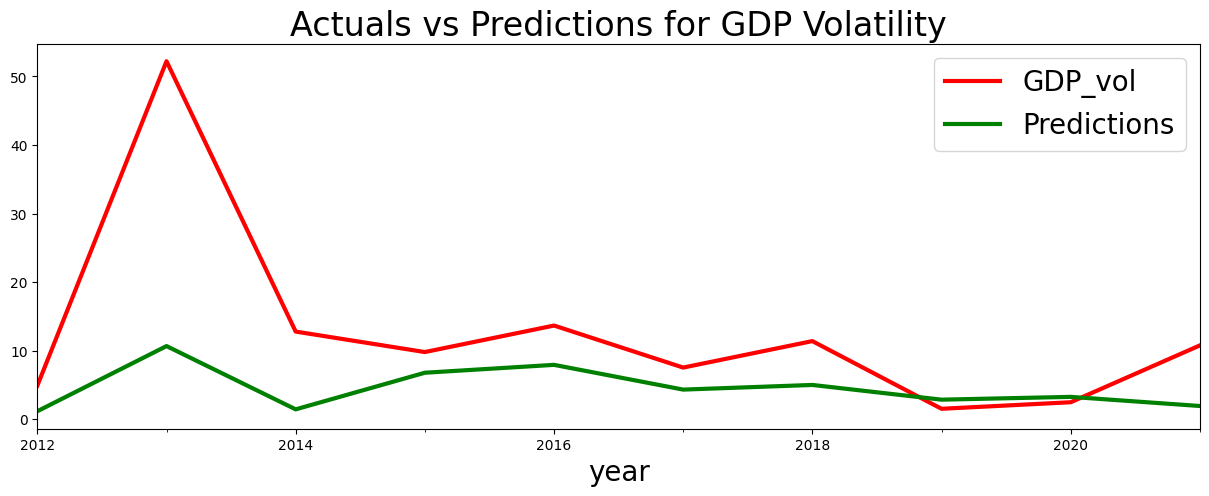

In [30]:
plt.rcParams["figure.figsize"] = 15, 5

predictions_df["GDP_vol"].abs().plot(color='red')
predictions_df["Predictions"].plot(color='green')

plt.title("Actuals vs Predictions for GDP Volatility")
plt.legend()
plt.show()

В промежутке 2019-2021 год модель не уловила дисперсию, однако на более длинном промежутке 2012-2021 мы видим участки, где модель как минимум уловила направление измененияй.

In [31]:
!pip freeze > requirements.txt